In [1]:
import requests
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import os 

from dotenv import load_dotenv

# Pulling S&P 500 Data

In [55]:
load_dotenv()
AV_API_KEY = os.getenv('AV_API_KEY')
BASE_URL = 'https://www.alphavantage.co/query?'
TICKER = 'SPY'

In [56]:
params = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",
    "symbol": TICKER,
    "outputsize":"full",
    "apikey": AV_API_KEY
}

resp = requests.get(BASE_URL,params=params)

In [57]:
ts = resp.json()['Time Series (Daily)']

In [58]:
close_ts = {datetime.strptime(tick, '%Y-%m-%d'):float(ts[tick]['5. adjusted close']) for tick in ts}

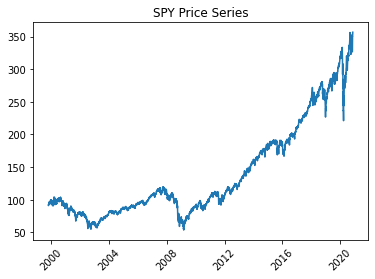

In [59]:
fig = sns.lineplot(x = close_ts.keys(),y = close_ts.values())
fig.set_title(f"{TICKER} Price Series")
plt.xticks(rotation=45)
plt.show()

In [60]:
price = pd.DataFrame.from_dict(close_ts,orient='index',columns=['SPY'])

In [61]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

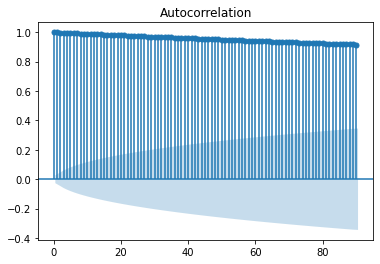

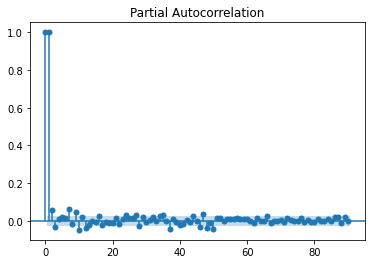

In [62]:
plot_acf(price[TICKER].to_numpy(),missing="drop",lags=90,fft=False)
plot_pacf(price[TICKER].to_numpy(),lags=90)
plt.show()

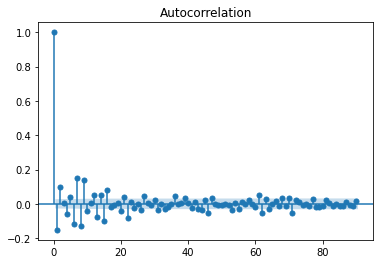

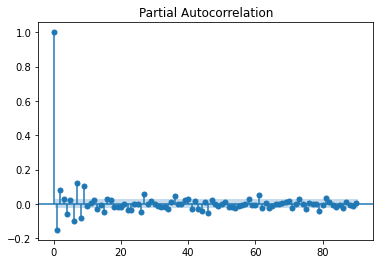

In [63]:
plot_acf(price[TICKER].diff(periods=-1).dropna().to_numpy(),missing="drop",lags=90,fft=False)
plot_pacf(price[TICKER].diff(periods=-1).dropna().to_numpy(),lags=90)
plt.show()

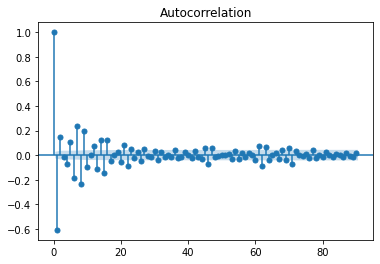

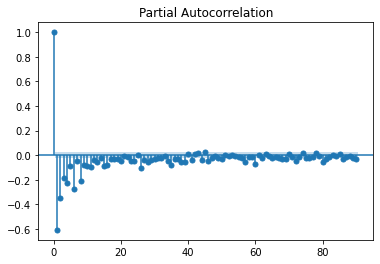

In [64]:
plot_acf(price[TICKER].diff(periods=-1).diff(periods=-1).dropna().to_numpy(),missing="drop",lags=90,fft=False)
plot_pacf(price[TICKER].diff(periods=-1).diff(periods=-1).dropna().to_numpy(),lags=90)
plt.show()

# Reversal Backtest

In [83]:
initial = 1000
price['daily_return'] = price.pct_change(1) + 1
price = price.sort_index().dropna()

In [107]:
def reversal_trade(r):
    if r <= 0.95:
        return 'BUY'
    elif r >= 1.05:
        return 'SELL'
    else:
        return 'HOLD'

In [108]:
price['trade'] = price.daily_return.apply(lambda r: reversal_trade(r))
price['next_day_return'] = price.daily_return.shift(-1)

In [109]:
price.head()

,SPY,daily_return,trade,next_day_return
1999-11-03,91.5574,1.006734,HOLD,1.007611
1999-11-04,92.2542,1.007611,HOLD,1.009842
1999-11-05,93.1622,1.009842,HOLD,1.000907
1999-11-08,93.2467,1.000907,HOLD,0.990601
1999-11-09,92.3703,0.990601,HOLD,1.007430


In [130]:
import numpy as np
np.product(price.next_day_return)

3.866863847160386

In [111]:
np.product(price.loc[price.trade != 'SELL'].next_day_return)

5.077480217793145

In [141]:
price.loc[price.trade == 'SELL']

,SPY,daily_return,trade,next_day_return
2000-01-07,98.7232,1.058077,SELL,1.003431
2002-07-24,59.1182,1.059663,SELL,0.991502
2008-10-13,79.2561,1.145197,SELL,0.985200
2008-10-20,77.2698,1.060079,SELL,0.970145
2008-10-28,73.3207,1.116854,SELL,0.992748
2008-11-13,71.2953,1.062339,SELL,0.950093
2008-11-21,62.1850,1.053944,SELL,1.069290
2008-11-24,66.4938,1.069290,SELL,1.007410
2009-03-10,56.8976,1.059609,SELL,1.006512
2009-03-23,65.2953,1.071829,SELL,0.980296


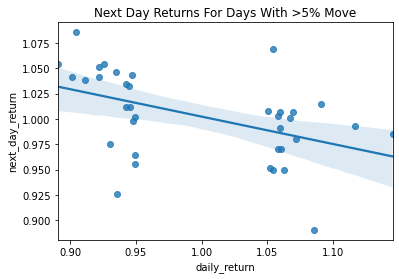

In [157]:
sub = price.loc[(price.daily_return > 1.05) | (price.daily_return < 0.95)]
fig = sns.regplot(x=sub.daily_return,y=sub.next_day_return)
fig.set_title('Next Day Returns For Days With >5% Move')
plt.show()

In [159]:
sub.corr()[['daily_return','next_day_return']]

,daily_return,next_day_return
SPY,0.075907,-0.086263
daily_return,1.000000,-0.470734
next_day_return,-0.470734,1.000000


In [240]:
capital = 90000
invested = 10000
buys = 0
sells = 0

for index, row in price.dropna().iterrows():
    if row['trade'] == 'BUY':
        
        if (capital > 0) & (invested != 0):    
            
            amt = capital*0.20
            invested += amt
            capital -= amt
            buys += 1
        
        elif invested == 0:
            
            amt = capital*0.95
            invested += amt
            capital -= amt
            
        invested = invested*row['next_day_return']
        
    else:
        
        invested = invested*row['next_day_return']
        
    

In [241]:
invested

437966.7620275095

In [242]:
capital

1297.0366926827026

In [220]:
buys

19

In [221]:
sells

0

In [229]:
invested = 100000

for index, row in price.dropna().iterrows():
  
    invested = invested*row['next_day_return']

In [230]:
invested

386686.38471603644

# Auto-ARIMA

In [12]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

In [13]:
price = price.sort_index(ascending=True)

In [14]:
# Estimate the number of differences using an ADF test:
n_adf = ndiffs(price, test='adf')  # -> 0

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(price, test='kpss')  # -> 0

# Or a PP test:
n_pp = ndiffs(price, test='pp')  # -> 0

In [15]:
fit = pm.auto_arima(price, start_p=15, start_q=1,
                             max_p=15, start_d=2, max_d=2, max_q=1, seasonal=False,trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(15,2,1)(0,0,0)[0] intercept   : AIC=21183.504, Time=38.47 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=25931.051, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=23486.885, Time=0.24 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=25929.051, Time=0.07 sec
 ARIMA(14,2,1)(0,0,0)[0] intercept   : AIC=21194.349, Time=31.69 sec
 ARIMA(15,2,0)(0,0,0)[0] intercept   : AIC=21430.028, Time=7.66 sec
 ARIMA(14,2,0)(0,0,0)[0] intercept   : AIC=21473.583, Time=4.85 sec
 ARIMA(15,2,1)(0,0,0)[0]             : AIC=inf, Time=17.99 sec

Best model:  ARIMA(15,2,1)(0,0,0)[0] intercept
Total fit time: 103.365 seconds


In [16]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5291
Model:              SARIMAX(15, 2, 1)   Log Likelihood              -10573.752
Date:                Mon, 09 Nov 2020   AIC                          21183.504
Time:                        22:26:54   BIC                          21301.825
Sample:                             0   HQIC                         21224.855
                               - 5291                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.544e-05      0.001      0.168      0.867      -0.001       0.001
ar.L1         -0.1160      0.005    -21.344      0.000      -0.127      -0.105
ar.L2          0.0529      0.006      9.565      0.000       0.042       0.064
ar.L3          0.0293      0.006      4.824      0.000       0.017       0.041
ar.L4         -0.0625      0.006    -10.024      0.000      -0.075      -0.050
ar.L5         -0.0063      0.006     -1.029      0.303      -0.018       0.006
ar.L6         -0.0806      0.006    -12.705      0.000      -0.093      -0.068
ar.L7          0.0950      0.007     13.775      0.000       0.081       0.109
ar.L8         -0.0736      0.006    -12.947      0.000      -0.085      -0.062
ar.L9          0.0870      0.007     12.263      0.000       0.073       0.101
ar.L10        -0.0178      0.006     -2.890      0.004      -0.030      -0.006
ar.L11         0.0018      0.007      0.252      0.801      -0.012       0.016
ar.L12         0.0173      0.007      2.326      0.020       0.003       0.032
ar.L13        -0.0376      0.008     -4.973      0.000      -0.052      -0.023
ar.L14        -0.0178      0.008     -2.356      0.018      -0.033      -0.003
ar.L15        -0.0516      0.007     -6.904      0.000      -0.066      -0.037
ma.L1         -0.9803      0.003   -387.466      0.000      -0.985      -0.975
sigma2         3.1827      0.021    153.361      0.000       3.142       3.223
===================================================================================
Ljung-Box (Q):                       95.19   Jarque-Bera (JB):            158055.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.41   Skew:                            -1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

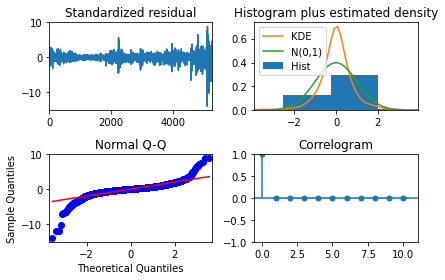

In [17]:
fig = fit.plot_diagnostics()
plt.tight_layout()
plt.show()

Average daily pct change -0.00017714645134760755
Median daily pct change -0.0006948791055709225


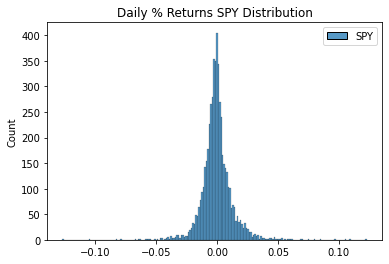

In [18]:
fig = sns.histplot(price.pct_change(-1))
print(f"Average daily pct change {price.pct_change(-1).mean()[0]}")
print(f"Median daily pct change {price.pct_change(-1).median()[0]}")
fig.set_title('Daily % Returns SPY Distribution')
plt.show()

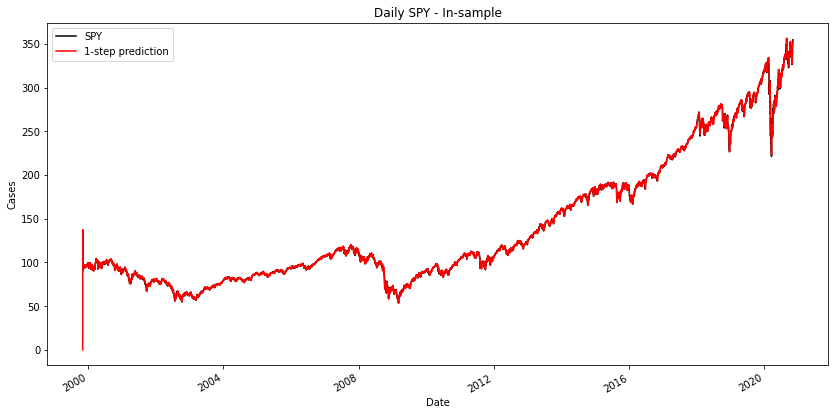

In [19]:
in_sample = fit.predict_in_sample()
pred = pd.DataFrame(in_sample,index=price.index,columns=['1-step prediction'])

ax = price.plot(label='observed', figsize=(14, 7),color='black')
pred.plot(ax=ax, label='forecast',color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.set_title(f"Daily {TICKER} - In-sample")
plt.legend()
plt.show()

In [20]:
steps= 7
future_index = pd.date_range(start=pd.datetime.now().date(),periods=steps,freq='B')
pred_future = pd.DataFrame(fit.predict(n_periods=steps,return_conf_int=False),index=future_index)
pred_future.columns =['predicted']

<ipython-input-20-ddc99777d63e>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  future_index = pd.date_range(start=pd.datetime.now().date(),periods=steps,freq='B')


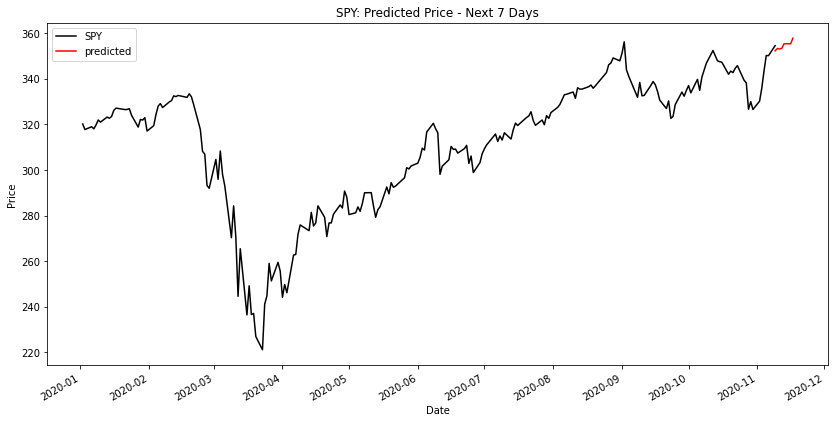

In [21]:
ax = price.loc['2020-01-01':'2020-11-09'].plot(label='observed', figsize=(14, 7),color='black')
pred_future.plot(ax=ax, label='forecast',color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title(f"{TICKER}: Predicted Price - Next {steps} Days")
plt.legend()
plt.show()

In [22]:
print(f"1 step-ahead forecast for {TICKER}: ${fit.predict(n_periods=1)[0].round(2)}")

1 step-ahead forecast for SPY: $352.29


In [43]:
price['dow'] = price.index.isocalendar().day
price['pct_change'] = price[TICKER].pct_change(-1)
price.groupby('dow').std()['pct_change']

dow
1    0.012495
2    0.012196
3    0.012482
4    0.011331
5    0.014161
Name: pct_change, dtype: float64

Fridays tend to be more volatile